# Choppiness Indexのデモ

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import talib
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## 指標を計算する関数の定義

In [2]:
def choppiness_index(data, period=14):
    # Calculate the True Range
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift(1))
    low_close = np.abs(data['Low'] - data['Close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    # Sum of the True Range over the given period
    atr = true_range.rolling(window=period).sum()
    # Calculate the difference between the highest high and lowest low over the period
    max_high = data['High'].rolling(window=period).max()
    min_low = data['Low'].rolling(window=period).min()
    # Calculate the Choppiness Index
    chop = 100 * np.log10(atr / (max_high - min_low)) / np.log10(period)
    return chop

## 株価データの読み込み

In [3]:
ticker = '9432.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
data = yf.download(ticker, start_date, end_date)
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]

[*********************100%***********************]  1 of 1 completed


In [4]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-01-24,150.800003,152.199997,150.600006,151.300003,154568400
2025-01-27,153.000000,153.600006,151.100006,151.399994,199461600
2025-01-28,153.899994,154.800003,152.300003,153.600006,185626100
2025-01-29,153.199997,154.100006,152.899994,153.399994,133472900
2025-01-30,152.800003,153.399994,151.899994,153.199997,48112000


## 指標の計算

In [5]:
# Calculate the Choppiness Index and ADX
data['CHOP'] = choppiness_index(data)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Close'], timeperiod=14)
# Drop any NaN values from rolling calculations
data.dropna(inplace=True)

## チャートの描画

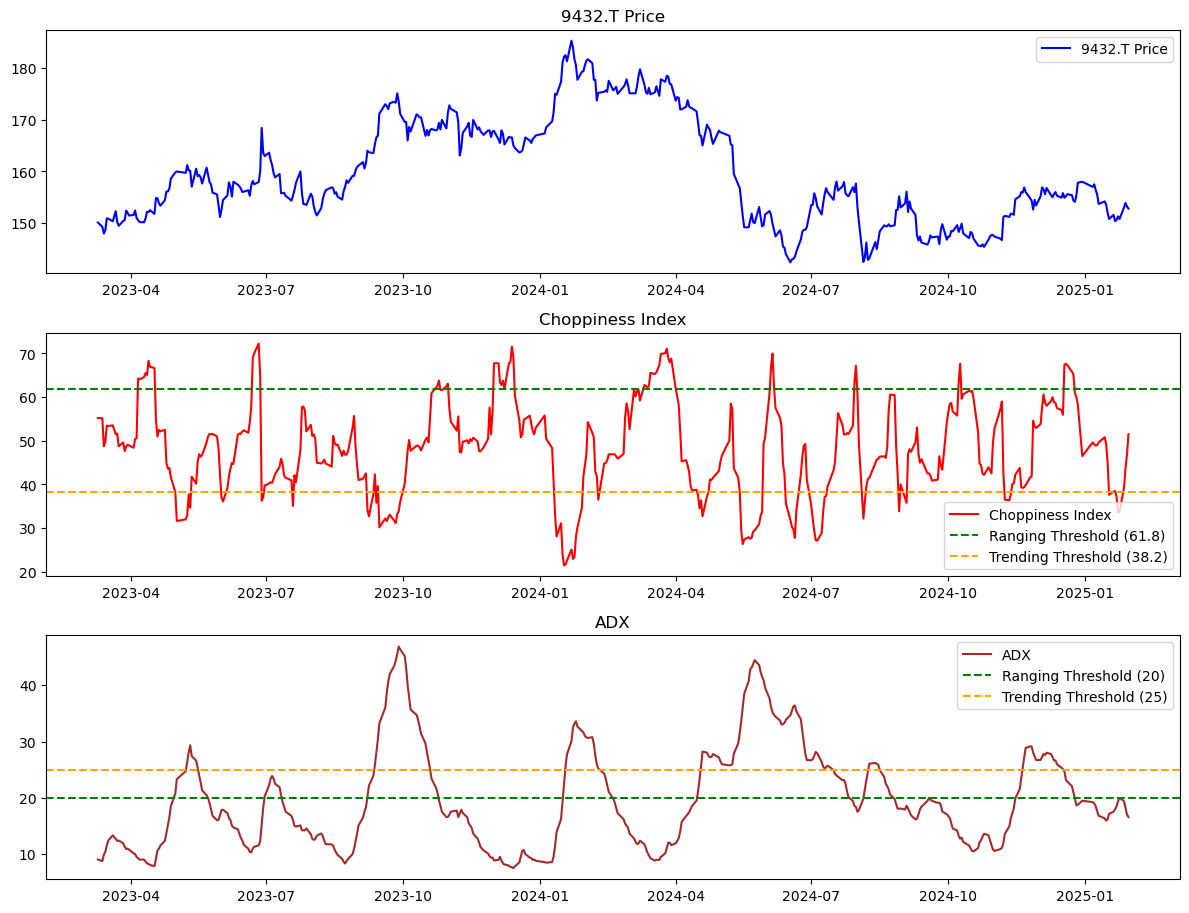

In [6]:
# Plot the Choppiness Index and ADX
plt.figure(figsize=(12, 9))
# Plot the price chart
plt.subplot(3, 1, 1)
plt.plot(data['Close'], label=f'{ticker} Price', color='blue')
plt.title(f'{ticker} Price')
plt.legend()
# Plot the Choppiness Index
plt.subplot(3, 1, 2)
plt.plot(data['CHOP'], label='Choppiness Index', color='red')
plt.axhline(y=61.8, color='green', linestyle='--', label='Ranging Threshold (61.8)')
plt.axhline(y=38.2, color='orange', linestyle='--', label='Trending Threshold (38.2)')
plt.title('Choppiness Index')
plt.legend()
plt.tight_layout()
# Plot the ADX
plt.subplot(3, 1, 3)
plt.plot(data['ADX'], label='ADX', color='brown')
plt.axhline(y=20, color='green', linestyle='--', label='Ranging Threshold (20)')
plt.axhline(y=25, color='orange', linestyle='--', label='Trending Threshold (25)')
plt.title('ADX')
plt.legend()
plt.savefig('ds250130a.png')
#plt.show()

## リストにある銘柄についてSMA, MACDとChoppiness Indexに基づく判定を行う

In [7]:
# 銘柄リストの指定
list_ticker = ['6920.T','8035.T','6146.T','6857.T','1605.T','9101.T','9107.T','4063.T',\
               '8306.T','7013.T','5803.T','6861.T','6954.T','7974.T','4385.T','6971.T']
# 期間の指定
end_date = datetime.today()
start_date = end_date - timedelta(days=730)
# 各銘柄についてシグナル判定を行い結果を縦連結する
df0 = pd.DataFrame()
for symbol in list_ticker:
    # yahooサイトからデータをダウンロード
    data = yf.download(symbol, start_date, end_date)
    data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]
    data['ticker'] = symbol
    df = data.reset_index()
    # 指標値の計算
    df['SMA_short'] = talib.SMA(df['Close'], timeperiod=5)
    df['SMA_long'] = talib.SMA(df['Close'], timeperiod=25)
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'], \
            fastperiod=12, slowperiod=26, signalperiod=9)
    df['CHOP'] = choppiness_index(df)
    # ポジションの判定
    df['SMA_buy'] = (df['SMA_short'] > df['SMA_long'])
    df['SMA_sell'] = (df['SMA_short'] < df['SMA_long'])
    df['MACD_buy'] = (df['MACD'] > df['MACD_signal'])
    df['MACD_sell'] = (df['MACD'] < df['MACD_signal'])
    df['CHOP_range'] = (df['CHOP'] > 61.8)
    df['CHOP_trend'] = (df['CHOP'] < 38.2)
    # 一銘柄のシグナル判定結果の最終行のみを元のデータに縦連結する
    df0 = pd.concat([df0,df.tail(1)],axis=0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
df_signal = df0.loc[:,['Date','ticker','Close',\
                       'SMA_buy','SMA_sell','MACD_buy','MACD_sell',\
                       'CHOP_range','CHOP_trend']].reset_index()
# シグナルメッセージの付与
df_signal["signal_str"] = np.nan
for irow in range(len(df_signal)):
    str_signal = ''
    if df_signal.SMA_buy[irow]:
        str_signal += ' SMA強気,'
    if df_signal.SMA_sell[irow]:
        str_signal += ' SMA弱気,'
    if df_signal.MACD_buy[irow]:
        str_signal += ' MACD強気,'
    if df_signal.MACD_sell[irow]:
        str_signal += ' MACD弱気,'
    if df_signal.CHOP_range[irow]:
        str_signal += ' CHOPレンジ,'
    if df_signal.CHOP_trend[irow]:
        str_signal += ' CHOPトレンド,'
    df_signal.loc[irow,"signal_str"] = str_signal
# シグナル一覧の表示
df_table = df_signal[['Date', 'ticker', 'signal_str']]
df_table

,Date,ticker,signal_str
0,2025-01-30,6920.T,"SMA弱気, MACD強気,"
1,2025-01-30,8035.T,"SMA弱気, MACD弱気,"
2,2025-01-30,6146.T,"SMA強気, MACD弱気,"
3,2025-01-30,6857.T,"SMA弱気, MACD弱気,"
4,2025-01-30,1605.T,"SMA弱気, MACD弱気, CHOPトレンド,"
5,2025-01-30,9101.T,"SMA弱気, MACD弱気,"
6,2025-01-30,9107.T,"SMA弱気, MACD弱気, CHOPトレンド,"
7,2025-01-30,4063.T,"SMA弱気, MACD弱気,"
8,2025-01-30,8306.T,"SMA強気, MACD強気,"
9,2025-01-30,7013.T,"SMA強気, MACD強気,"
